In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt


In [2]:
model = pybamm.BaseModel()


In [3]:
c = pybamm.Variable("c", domain="unit line")
mu = pybamm.Variable("mu", domain="unit line")
F = pybamm.Variable("F", domain="unit line")


In [4]:
D = c * (1 - c)  # diffusion coefficient
omega = pybamm.Scalar(3)  # enthalpy of mixing per site
kappa = pybamm.Scalar(0.005) # gradient energy penalty coefficient
I = 0 # insertion current density
F = D * pybamm.grad(mu) # flux


In [5]:
# governing equations
dcdt = pybamm.div(F)
mu_gov = pybamm.log(c / (1 - c)) + omega * (1 - 2 * c) - kappa * pybamm.div(pybamm.grad(c)) - mu  # chemical potential


In [6]:
model.rhs = {c: dcdt}
model.algebraic = {mu: mu_gov}


In [7]:
x = pybamm.SpatialVariable("x", domain="unit line")
c0 = 0.5 * pybamm.tanh(10 * (x - 0.5)) + 0.5 # initial concentration
mu0 = pybamm.log(c0 / (1 - c0)) + omega * (1 - 2 * c0) - kappa * pybamm.div(pybamm.grad(c0))  # initial chemical potential
model.initial_conditions = {c: c0, mu: mu0}


In [8]:
c_surf = pybamm.BoundaryValue(
    c, "right" # surface concentration
)

model.boundary_conditions = {
    c: {"left": (0, "Neumann"), "right": (0, "Neumann")},
    c0 : {"left": (0.5 * pybamm.tanh(10 * (0 - 0.5)) + 0.5, "Dirichlet"), "right": (0.5 * pybamm.tanh(10 * (1 - 0.5)) + 0.5, "Dirichlet")},
    mu: {"left": (0, "Neumann"), "right": (I / (c_surf * (1 - c_surf)), "Neumann")},
    # F: {"left": (0, "Dirichlet"), "right": (I, "Dirichlet")},
}


In [9]:
model.variables = {"c": c, "mu": mu}


In [10]:
# define geometry
geometry = {"unit line": {x: {"min": pybamm.Scalar(0), "max": pybamm.Scalar(1)}}}


In [11]:
# mesh and discretise
submesh_types = {"unit line": pybamm.Uniform1DSubMesh}
var_pts = {x: 101}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)


In [12]:
spatial_methods = {"unit line": pybamm.FiniteVolume()}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model)


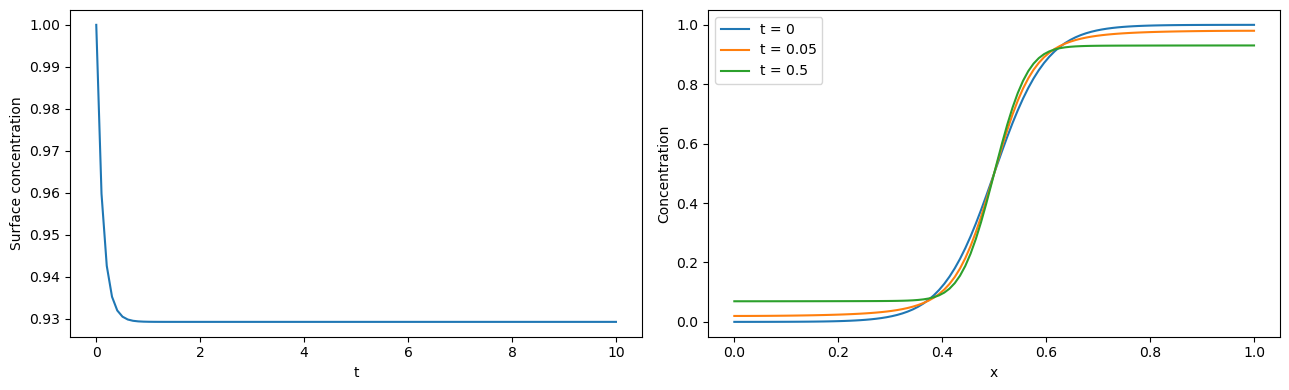

In [13]:
# solve
# solver = pybamm.ScipySolver()
solver = pybamm.CasadiSolver(mode="safe")
t = np.linspace(0, 10, 100)
solution = solver.solve(model, t)

# post-process, so solution can be called at any time t or space x
c = solution["c"]
mu = solution["mu"]

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

ax1.plot(solution.t, c(solution.t, x=1))
ax1.set_xlabel("t")
ax1.set_ylabel("Surface concentration")
x = np.linspace(0, 1, 100)
ax2.plot(x, c(t=0, x=x), label="t = 0")
ax2.plot(x, c(t=0.05, x=x), label="t = 0.05")
ax2.plot(x, c(t=0.5, x=x), label="t = 0.5")
ax2.set_xlabel("x")
ax2.set_ylabel("Concentration")
plt.legend()
plt.tight_layout()
plt.show()
